In [38]:
import pandas as pd
import japanize_matplotlib

# 前処理

In [40]:
df = pd.read_csv('../data/0617_result_question.csv')
#列名クラスと人を消したい

#点数が高いほど、遅延したくなる
df["2-1"] = df["2-1"].map(lambda x:5-x)
df["2-3"] = df["2-3"].map(lambda x:5-x)
df["2-7"] = df["2-7"].map(lambda x:5-x)
df["3-4.国"] = df["3-4.国"].map(lambda x:5-x)
df["3-5.国"] = df["3-5.国"].map(lambda x:5-x)
df["3-4.英"] = df["3-4.英"].map(lambda x:5-x)
df["3-5.英"] = df["3-5.英"].map(lambda x:5-x)
df["3-4.数"] = df["3-4.数"].map(lambda x:5-x)
df["3-5.数"] = df["3-5.数"].map(lambda x:5-x)

df = df.drop(['クラス', '人'], axis=1)
df_math = df[[ '学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.数学', '3-2.数',
       '3-3.数', '3-4.数', '3-5.数']]

df_english = df[['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.英語',  '3-2.英',  '3-3.英', '3-4.英', '3-5.英']]
df_japanese = df[['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.国',  '3-2.国',  '3-3.国', '3-4.国', '3-5.国']]

#MBTI列以外で欠損ちがある行を削除
df_math = df_math.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.数学', '3-2.数','3-3.数', '3-4.数', '3-5.数'])
#MBTI列以外で欠損ちがある行を削除
df_english = df_english.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.英語',  '3-2.英',  '3-3.英', '3-4.英', '3-5.英'])
#MBTI列以外で欠損ちがある行を削除
df_japanese = df_japanese.dropna(subset=['学年', '性別', '2-1', '2-2', '2-3', '2-4', '2-5', '2-6', '2-7', '3-1.国',  '3-2.国',  '3-3.国', '3-4.国', '3-5.国'])

#数学のデータフレームを作成
df_math["Y_math"] = df_math["3-1.数学"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_math = df_math.drop("3-1.数学", axis=1)
df_math = df_math.astype(int)
df_math = df_math.reset_index(drop=True)

#英語のデータフレームを作成
df_english["Y_english"] = df_english["3-1.英語"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_english = df_english.drop("3-1.英語", axis=1)
df_english = df_english.astype(int)
df_english = df_english.reset_index(drop=True)

#国語のデータフレームを作成
df_japanese["Y_japanese"] = df_japanese["3-1.国"].map(lambda x: 1 if x == "土" or x == "未"  else 0)
df_japanese = df_japanese.drop("3-1.国", axis=1)
df_japanese = df_japanese.astype(int)
df_japanese = df_japanese.reset_index(drop=True)

# 因子分析(バリマックス回転)

In [41]:
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler

# データを標準化
sc = StandardScaler()
df_math_std = sc.fit_transform(df_math)

# 因子分析のインスタンスを生成と適用
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(df_math_std)

# 因子負荷量を出力
loadings = pd.DataFrame(fa.loadings_, columns=['第1因子', '第2因子', '第3因子'], index=df_math.columns)
print(loadings)

# 因子得点を算出
factor_score = fa.transform(df_math_std)

# 因子得点をデータフレームに変換
factor_score_df = pd.DataFrame(factor_score, columns=['第1因子', '第2因子', '第3因子'])

# 元のデータフレームと結合
df_math = pd.concat([df_math, factor_score_df], axis=1)

            第1因子      第2因子      第3因子
学年      0.036164 -0.217001 -0.750266
性別      0.086586 -0.296544 -0.019427
2-1     0.374089  0.740309 -0.139645
2-2     0.501176  0.000037  0.316040
2-3     0.013842  0.090598 -0.384269
2-4    -0.484872 -0.235942  0.025435
2-5     0.557271 -0.380689  0.038022
2-6     0.704248 -0.161761 -0.314970
2-7     0.509679  0.105271  0.192467
3-2.数  -0.020691  0.387755  0.779283
3-3.数   0.027421  0.759570  0.132765
3-4.数   0.330001 -0.470629  0.578583
3-5.数   0.318077  0.513712  0.201612
Y_math  0.575879  0.063951 -0.085864


# ロジスティック回帰

テストデータに対する正答率： 0.900


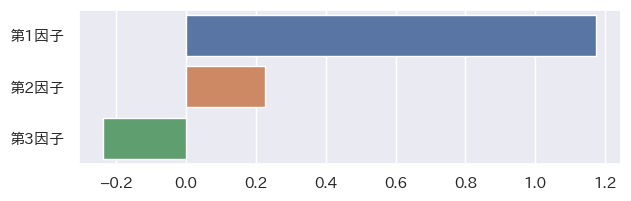

In [42]:
# 因子分析した結果をもとにロジスティック回帰を行う
# ロジスティック回帰のインスタンスを生成
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)

# ロジスティック回帰を実行
#テストデータと分割
from sklearn.model_selection import train_test_split
X = df_math[['第1因子', '第2因子', '第3因子']]
y = df_math['Y_math']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr.fit(X_train, y_train)

# テストデータを予測
y_pred = lr.predict(X_test)

# テストデータに対する正答率を出力
print('テストデータに対する正答率： %.3f' % accuracy_score(y_test, y_pred))

#回帰係数を出力
# lr.coef_を可視化
coef_df = pd.DataFrame(lr.coef_, columns=['第1因子', '第2因子', '第3因子'])
coef_df
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 2))
sns.set(font='IPAexGothic')
sns.barplot(data=coef_df, orient='h')
plt.show()

